# 데이터 EDA ipython notebook


In [1]:
from collections import Counter
from datetime import timedelta, datetime
import glob
from itertools import chain
import json
import os, sys
import re


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters
import seaborn as sns

In [3]:
sys.path.append(os.pardir)
import config as conf

In [4]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
font_path = '/Users/ohyeji/fonts/NanumGothic.ttf'
font_name = fm.FontProperties(fname=font_path, size=10).get_name()
plt.rc('font', family=font_name, size=12)
plt.rcParams["figure.figsize"] = (20, 10)
register_matplotlib_converters()


In [5]:
directory = conf.data_root

## 1. Data Read


### a. Magazine.json

In [7]:
magazine = pd.read_json(directory + 'magazine.json', lines=True)

In [127]:
magazine.shape

(27967, 2)

In [128]:
magazine.head()

,magazine_tag_list,id
0,"[브런치북, 육아일기, 대화법, 들려주고픈이야기]",38842
1,"[tea, food]",11540
2,[food],11541
3,"[브런치북, 일상, 시, 사람]",11546
4,"[감성에세이, 노래, 음악에세이]",11544


### b. Metadata.json

In [129]:
metadata = pd.read_json(directory + 'metadata.json', lines=True)

In [130]:
metadata.shape

(643104, 9)

In [131]:
metadata.head()

,magazine_id,user_id,title,keyword_list,display_url,sub_title,reg_ts,article_id,id
0,8982,@bookdb,"사진으로 옮기기에도 아까운, 리치필드 국립공원","[여행, 호주, 국립공원]",https://brunch.co.kr/@bookdb/782,세상 어디에도 없는 호주 Top 10,1474944427000,782,@bookdb_782
1,12081,@kohwang56,[시] 서러운 봄,"[목련꽃, 아지랑이, 동행]",https://brunch.co.kr/@kohwang56/81,,1463092749000,81,@kohwang56_81
2,0,@hannahajink,무엇을 위해,[],https://brunch.co.kr/@hannahajink/4,무엇 때문에,1447997287000,4,@hannahajink_4
3,16315,@bryceandjuli,싫다,"[감정, 마음, 위로]",https://brunch.co.kr/@bryceandjuli/88,,1491055161000,88,@bryceandjuli_88
4,29363,@mijeongpark,Dubliner#7,"[유럽여행, 더블린, 아일랜드]",https://brunch.co.kr/@mijeongpark/34,#7. 내 친구의 집은 어디인가,1523292942000,34,@mijeongpark_34


### c. Users.json


In [132]:
users = pd.read_json(directory + '/users.json', lines=True)

In [133]:
users.shape


(310758, 3)

In [134]:
users.head()


,keyword_list,following_list,id
0,[],"[@perytail, @brunch]",#901985d8bc4c481805c4a4f911814c4a
1,[],"[@holidaymemories, @wadiz, @sciforus, @dailydu...",#1fd89e9dcfa64b45020d9eaca54e0eed
2,[],"[@commerceguy, @sunsutu, @kakao-it, @joohoonja...",#1d94baaea71a831e1f33e1c6bd126ed5
3,[],"[@amberjeon48, @forsy20, @nemotokki, @hawann, ...",#04641c01892b12dc018b1410e4928c0d
4,[],"[@dwcha7342, @iammento, @kakao-it, @dkam, @ant...",#65bcaff862aadff877e461f54187ab62


### d. Read Files

In [135]:
read_file_lst = glob.glob(directory + 'read/*')


In [136]:
exclude_file_lst = ['read.tar']


In [137]:
read_df_lst = []
for f in read_file_lst:
    file_name = os.path.basename(f)
    if file_name in exclude_file_lst:
        print(file_name)
    else:
        df_temp = pd.read_csv(f, header=None, names=['raw'])
        df_temp['dt'] = file_name[:8]
        df_temp['hr'] = file_name[8:10]
        df_temp['user_id'] = df_temp['raw'].str.split(' ').str[0]
        df_temp['article_id'] = df_temp['raw'].str.split(' ').str[1:].str.join(' ').str.strip()
        read_df_lst.append(df_temp)

In [138]:
read = pd.concat(read_df_lst)

In [139]:
read.shape


(3507097, 5)

In [140]:
read.head()

,raw,dt,hr,user_id,article_id
0,#a055d0c3520e1c002531001928217887 @charlessay_...,20181121,14,#a055d0c3520e1c002531001928217887,@charlessay_30 @wal8am_27 @uglyduckmin_40 @ant...
1,#a9cba8bf098c149170315d4cd8d3082e @jinbread_88...,20181121,14,#a9cba8bf098c149170315d4cd8d3082e,@jinbread_88 @jinbread_87 @jinbread_89
2,#207c8cb590a843e247b9fe7fdd0e5281 @sangheeshyn...,20181121,14,#207c8cb590a843e247b9fe7fdd0e5281,@sangheeshyn_66
3,#d76887a5b30adbf793f742c6f67b57bd @tenbody_150...,20181121,14,#d76887a5b30adbf793f742c6f67b57bd,@tenbody_1506 @tenbody_1506
4,#b260d83247a4d9e3b22143c950f7f471 @maumdal_257...,20181121,14,#b260d83247a4d9e3b22143c950f7f471,@maumdal_257 @maumdal_257


#### 탐색하기 좋은 데이터 포맷으로 변경

In [141]:
def chainer(s):
    return list(chain.from_iterable(s.str.split(' ')))

In [142]:
read_cnt_by_user = read['article_id'].str.split(' ').map(len)

In [143]:
read_raw = pd.DataFrame({'dt': np.repeat(read['dt'], read_cnt_by_user),
                         'hr': np.repeat(read['hr'], read_cnt_by_user),
                         'user_id': np.repeat(read['user_id'], read_cnt_by_user),
                         'article_id': chainer(read['article_id'])})

In [144]:
read_raw.shape

(22110706, 4)

In [145]:
read_raw.head()

,dt,hr,user_id,article_id
0,20181121,14,#a055d0c3520e1c002531001928217887,@charlessay_30
0,20181121,14,#a055d0c3520e1c002531001928217887,@wal8am_27
0,20181121,14,#a055d0c3520e1c002531001928217887,@uglyduckmin_40
0,20181121,14,#a055d0c3520e1c002531001928217887,@anti-essay_133
0,20181121,14,#a055d0c3520e1c002531001928217887,@roysday_125


In [146]:
print("전체 데이터 건수:", read_raw.shape)
print("중복 소비를 제외한 데이터 건수:", read_raw[['user_id', 'article_id']].drop_duplicates().shape)
print("Unique 독자 수:", len(read_raw['user_id'].unique()))
print("소비된 Unique 글 수:", len(read_raw['article_id'].unique()))

전체 데이터 건수: (22110706, 4)
중복 소비를 제외한 데이터 건수: (12597878, 2)
Unique 독자 수: 306222
소비된 Unique 글 수: 505841


## 2. EDA
- 1. 글 수
- 2. 글 소비
- 3. 경과일에 따른 글 소비 변화
- 4. 위클리 매거진
- 5. 유저
- 6. Following List

### 1. 글 수

### a. metadata 전처리

In [190]:
atc = metadata.copy()

In [191]:
atc.head()

,magazine_id,user_id,title,keyword_list,display_url,sub_title,reg_ts,article_id,id
0,8982,@bookdb,"사진으로 옮기기에도 아까운, 리치필드 국립공원","[여행, 호주, 국립공원]",https://brunch.co.kr/@bookdb/782,세상 어디에도 없는 호주 Top 10,1474944427000,782,@bookdb_782
1,12081,@kohwang56,[시] 서러운 봄,"[목련꽃, 아지랑이, 동행]",https://brunch.co.kr/@kohwang56/81,,1463092749000,81,@kohwang56_81
2,0,@hannahajink,무엇을 위해,[],https://brunch.co.kr/@hannahajink/4,무엇 때문에,1447997287000,4,@hannahajink_4
3,16315,@bryceandjuli,싫다,"[감정, 마음, 위로]",https://brunch.co.kr/@bryceandjuli/88,,1491055161000,88,@bryceandjuli_88
4,29363,@mijeongpark,Dubliner#7,"[유럽여행, 더블린, 아일랜드]",https://brunch.co.kr/@mijeongpark/34,#7. 내 친구의 집은 어디인가,1523292942000,34,@mijeongpark_34


In [192]:
atc['reg_datetime'] = atc['reg_ts'].apply(lambda x : datetime.fromtimestamp(x/1000.0))
atc.loc[atc['reg_datetime'] == atc['reg_datetime'].min(), 'reg_datetime'] = datetime(2090, 12, 31)
atc['reg_dt'] = atc['reg_datetime'].dt.date
atc['type'] = atc['magazine_id'].apply(lambda x : '개인' if x == 0.0 else '매거진')

In [194]:
# 컬럼명 변경

atc.columns = ['magazine_id', 'author_id', 'title', 'keyword_list', 'display_url', 'sub_title', 'reg_ts', 'id', 'article_id', 'reg_datetime', 'reg_dt', 'type']



In [197]:
atc.head()


,magazine_id,author_id,title,keyword_list,display_url,sub_title,reg_ts,id,article_id,reg_datetime,reg_dt,type
0,8982,@bookdb,"사진으로 옮기기에도 아까운, 리치필드 국립공원","[여행, 호주, 국립공원]",https://brunch.co.kr/@bookdb/782,세상 어디에도 없는 호주 Top 10,1474944427000,782,@bookdb_782,2016-09-27 11:47:07,2016-09-27,매거진
1,12081,@kohwang56,[시] 서러운 봄,"[목련꽃, 아지랑이, 동행]",https://brunch.co.kr/@kohwang56/81,,1463092749000,81,@kohwang56_81,2016-05-13 07:39:09,2016-05-13,매거진
2,0,@hannahajink,무엇을 위해,[],https://brunch.co.kr/@hannahajink/4,무엇 때문에,1447997287000,4,@hannahajink_4,2015-11-20 14:28:07,2015-11-20,개인
3,16315,@bryceandjuli,싫다,"[감정, 마음, 위로]",https://brunch.co.kr/@bryceandjuli/88,,1491055161000,88,@bryceandjuli_88,2017-04-01 22:59:21,2017-04-01,매거진
4,29363,@mijeongpark,Dubliner#7,"[유럽여행, 더블린, 아일랜드]",https://brunch.co.kr/@mijeongpark/34,#7. 내 친구의 집은 어디인가,1523292942000,34,@mijeongpark_34,2018-04-10 01:55:42,2018-04-10,매거진


### b. 등록일자별 글 수

In [198]:
atc_cnt_by_reg_dt = atc.groupby('reg_dt', as_index=False)['article_id'].count()


Text(0, 0.5, '글 수')

/Users/ohyeji/anaconda3/envs/tf2/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 46321 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/ohyeji/anaconda3/envs/tf2/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 47197 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/ohyeji/anaconda3/envs/tf2/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 51068 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/ohyeji/anaconda3/envs/tf2/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 51088 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/ohyeji/anaconda3/envs/tf2/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 48324 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/ohyeji/anaconda3/envs/tf2/li

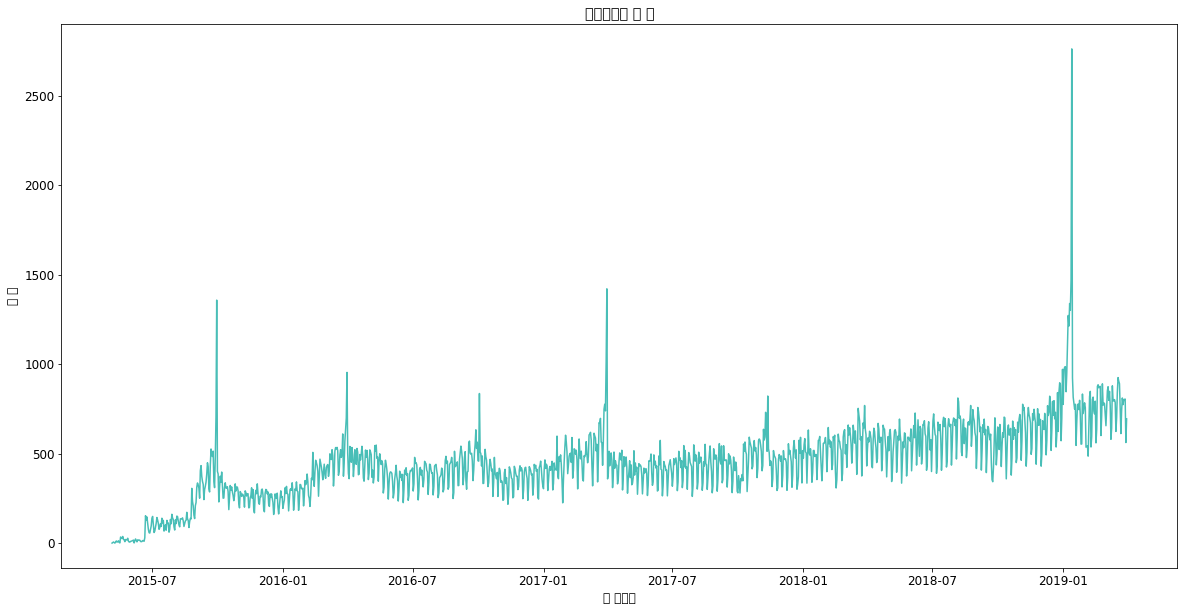

In [199]:
sns.lineplot(data=atc_cnt_by_reg_dt[:-1], x='reg_dt', y='article_id', color='#49beb7')
plt.title('등록일자별 글 수')
plt.xlabel('글 등록일')
plt.ylabel('글 수')

## 2. 글 소비


### a. 글별 소비수 통계

In [200]:
# 글당 유저가 본 횟수(?)
atc_read_cnt = read_raw[read_raw.article_id != ''].groupby('article_id')['user_id'].count()


In [201]:
atc_read_cnt

article_id
#00700c454af49d5c9a36a13fcba01d0a_1      112
#00700c454af49d5c9a36a13fcba01d0a_10      24
#00700c454af49d5c9a36a13fcba01d0a_100     37
#00700c454af49d5c9a36a13fcba01d0a_101     32
#00700c454af49d5c9a36a13fcba01d0a_102     40
                                        ... 
@zzzaam_6                                114
@zzzaam_7                                 42
@zzzaam_8                                 80
@zzzaam_9                                 43
@zzzwhite_4                                2
Name: user_id, Length: 505840, dtype: int64

In [202]:
# 글별 소비수 통계
atc_read_cnt.describe()


count    505840.000000
mean         43.700988
std         302.292764
min           1.000000
25%           3.000000
50%           8.000000
75%          25.000000
max       97206.000000
Name: user_id, dtype: float64

In [203]:
# 글별 소비수 85% 95% 기준 값
atc_read_cnt.quantile([0.85, 0.95])


0.85     47.0
0.95    141.0
Name: user_id, dtype: float64

In [204]:
atc_read_cnt = atc_read_cnt.reset_index()
atc_read_cnt.columns = ['article_id', 'read_cnt']

In [205]:
atc_read_cnt.tail()


,article_id,read_cnt
505835,@zzzaam_6,114
505836,@zzzaam_7,42
505837,@zzzaam_8,80
505838,@zzzaam_9,43
505839,@zzzwhite_4,2


In [206]:
atc.head()

,magazine_id,author_id,title,keyword_list,display_url,sub_title,reg_ts,id,article_id,reg_datetime,reg_dt,type
0,8982,@bookdb,"사진으로 옮기기에도 아까운, 리치필드 국립공원","[여행, 호주, 국립공원]",https://brunch.co.kr/@bookdb/782,세상 어디에도 없는 호주 Top 10,1474944427000,782,@bookdb_782,2016-09-27 11:47:07,2016-09-27,매거진
1,12081,@kohwang56,[시] 서러운 봄,"[목련꽃, 아지랑이, 동행]",https://brunch.co.kr/@kohwang56/81,,1463092749000,81,@kohwang56_81,2016-05-13 07:39:09,2016-05-13,매거진
2,0,@hannahajink,무엇을 위해,[],https://brunch.co.kr/@hannahajink/4,무엇 때문에,1447997287000,4,@hannahajink_4,2015-11-20 14:28:07,2015-11-20,개인
3,16315,@bryceandjuli,싫다,"[감정, 마음, 위로]",https://brunch.co.kr/@bryceandjuli/88,,1491055161000,88,@bryceandjuli_88,2017-04-01 22:59:21,2017-04-01,매거진
4,29363,@mijeongpark,Dubliner#7,"[유럽여행, 더블린, 아일랜드]",https://brunch.co.kr/@mijeongpark/34,#7. 내 친구의 집은 어디인가,1523292942000,34,@mijeongpark_34,2018-04-10 01:55:42,2018-04-10,매거진


In [207]:
atc_read_cnt = pd.merge(atc_read_cnt, atc, how='left', left_on='article_id', right_on='article_id')


In [208]:
atc_read_cnt.tail()

,article_id,read_cnt,magazine_id,author_id,title,keyword_list,display_url,sub_title,reg_ts,id,reg_datetime,reg_dt,type
505835,@zzzaam_6,114,0.0,@zzzaam,좋은 제품 UX 디자인을 위한 9가지 방법,"[디자인, UX, design]",https://brunch.co.kr/@zzzaam/6,Hacking Product Design,1.489403e+12,6.0,2017-03-13 20:08:01,2017-03-13,개인
505836,@zzzaam_7,42,0.0,@zzzaam,반복적 디자인에 대한 소고,"[UX, 전략, 사용성]",https://brunch.co.kr/@zzzaam/7,Iteration is not design,1.490278e+12,7.0,2017-03-23 23:00:17,2017-03-23,개인
505837,@zzzaam_8,80,0.0,@zzzaam,인공지능과 미래의 디자인: 2025년의 디자이너,"[인공지능, AI, 디자인]",https://brunch.co.kr/@zzzaam/8,AI와 휴머니티의 간극,1.493136e+12,8.0,2017-04-26 00:57:34,2017-04-26,개인
505838,@zzzaam_9,43,0.0,@zzzaam,디자인팀에 작가가 필요한 이유,"[UX, 작가, 글쓰기]",https://brunch.co.kr/@zzzaam/9,Writers + Designers = A match made in he,1.496501e+12,9.0,2017-06-03 23:39:22,2017-06-03,개인
505839,@zzzwhite_4,2,0.0,@zzzwhite,너는 희망이다.,"[감성그림, 희망, 엄마]",https://brunch.co.kr/@zzzwhite/4,감성드로잉,1.467290e+12,4.0,2016-06-30 21:30:54,2016-06-30,개인


In [209]:
atc_read_cnt.shape


(505840, 13)

In [210]:
# metadata를 찾을 수 없는 소비 로그 제외
atc_read_cnt_nn = atc_read_cnt[atc_read_cnt['id'].notnull()]

In [211]:
# metadata를 찾을 수 없는 로그를 제외한 후 글별 소비수 통계
atc_read_cnt_nn['read_cnt'].describe()

count    476147.000000
mean         43.904592
std         304.873256
min           1.000000
25%           3.000000
50%           8.000000
75%          25.000000
max       97206.000000
Name: read_cnt, dtype: float64

In [212]:
# 글별 소비수 90% 95% 기준 값
atc_read_cnt_nn['read_cnt'].quantile([0.90, 0.95])

0.90     72.0
0.95    142.0
Name: read_cnt, dtype: float64

In [213]:
# 소비수 기준 분류값
def get_class(x):
    if x >= 142:
        result = '5%'
    elif x >= 72:
        result = '10%'
    elif x >= 25:
        result = '25%'
    elif x >= 8:
        result = '50%'
    elif x >= 3:
        result = '75%'
    else:
        result = '100%'
    return result

In [214]:
atc_read_cnt_nn['class'] = atc_read_cnt_nn['read_cnt'].map(get_class)


/Users/ohyeji/anaconda3/envs/tf2/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [215]:
atc_read_cnt_nn.head()

,article_id,read_cnt,magazine_id,author_id,title,keyword_list,display_url,sub_title,reg_ts,id,reg_datetime,reg_dt,type,class
5417,@002_10,2,0.0,@002,'80% 안심계란' 포기하게 한 20% 살충제 계란,"[계란, 살충제, 피해]",https://brunch.co.kr/@002/10,정직한 농가에 대한 피해보상은 소비자 신뢰를 돌려주는 것,1.504448e+12,10.0,2017-09-03 23:12:35,2017-09-03,개인,100%
5418,@002_2,6,0.0,@002,청년들은 '왜' 농촌으로 갔을까?,"[귀촌, 농촌, 청년농업인]",https://brunch.co.kr/@002/2,삶의 가치를 찾아 유랑하는 청년들의 'YOLO 라이프',1.501030e+12,2.0,2017-07-26 09:46:45,2017-07-26,개인,75%
5419,@002jesus_1,10,0.0,@002jesus,우리는 왜 가난해야 하나요?,"[후원, 기부, 비영리]",https://brunch.co.kr/@002jesus/1,비영리를 바라보는 편견들 (1),1.549456e+12,1.0,2019-02-06 21:18:49,2019-02-06,개인,50%
5420,@002paper_2,3,0.0,@002paper,할수 있는 것과 하고 싶은 것,"[제주, 서울생활, 서울]",https://brunch.co.kr/@002paper/2,현실과 꿈의 거리..,1.470905e+12,2.0,2016-08-11 17:49:42,2016-08-11,개인,75%
5421,@002paper_3,2,0.0,@002paper,긍정적으로 생각하며 주문을 걸기..,"[바램, 일상에세이, 긍정]",https://brunch.co.kr/@002paper/3,된다. 된다. 될거다....,1.470913e+12,3.0,2016-08-11 19:58:52,2016-08-11,개인,100%


### b. 등록일자별 글 소비수


Text(0, 0.5, '글 소비수')

/Users/ohyeji/anaconda3/envs/tf2/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 46321 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/ohyeji/anaconda3/envs/tf2/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 47197 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/ohyeji/anaconda3/envs/tf2/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 51068 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/ohyeji/anaconda3/envs/tf2/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 51088 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/ohyeji/anaconda3/envs/tf2/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 48324 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/ohyeji/anaconda3/envs/tf2/li

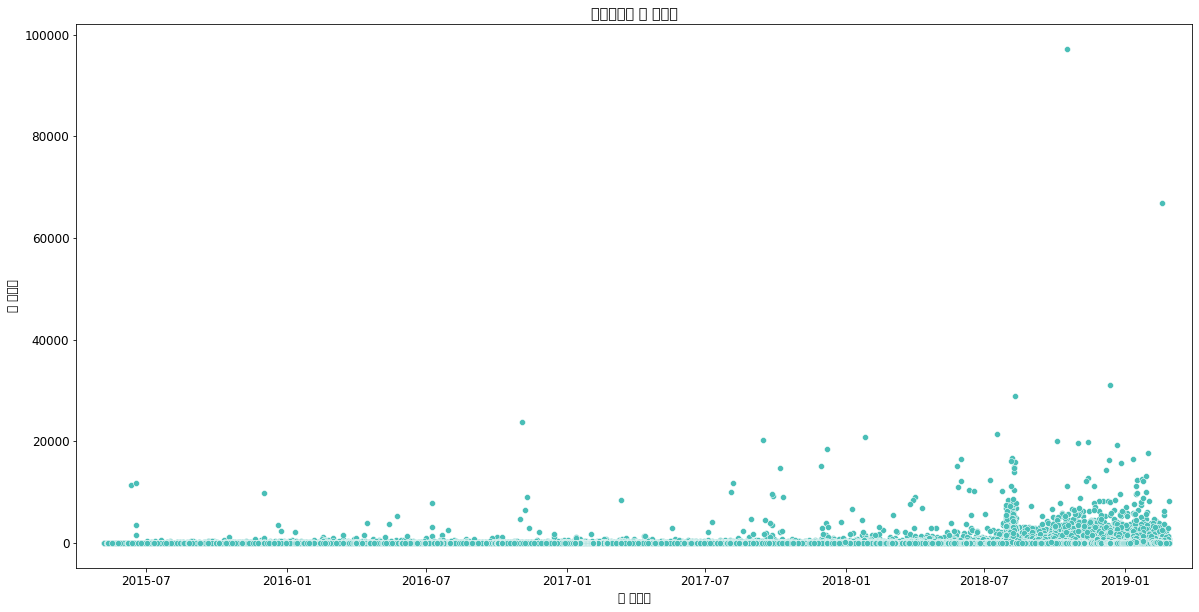

In [217]:
lm = sns.scatterplot(data=atc_read_cnt_nn, x='reg_dt', y='read_cnt', color='#49beb7')
lm.set(xlim=(datetime.date(datetime(2015, 4, 1)), datetime.date(datetime(2019, 3, 30))))
plt.title('등록일자별 글 소비수')
plt.xlabel('글 등록일')
plt.ylabel('글 소비수')


- 두 개의 아티클이 글 소비수가 매우 높음
- 그래프를 자세히 보기 위해 두 개의 아티클을 제외하고 다시 그려보자

In [218]:
atc_read_cnt_nn.sort_values(by='read_cnt', ascending=False).head(2)


,article_id,read_cnt,magazine_id,author_id,title,keyword_list,display_url,sub_title,reg_ts,id,reg_datetime,reg_dt,type,class
63061,@brunch_141,97206,0.0,@brunch,브런치 작가가 함께 빨강머리 앤을 그리고 쓰다.,"[브런치X빨강머리앤, 빨강머리앤, 출판, 작가]",https://brunch.co.kr/@brunch/141,글·그림 작가 파트너 프로젝트,1.539742e+12,141.0,2018-10-17 11:11:22,2018-10-17,개인,5%
63070,@brunch_151,66903,0.0,@brunch,"브런치 무비 패스, 영화의 진한 여운을 나누세요","[브런치, 시사회, 브런치무비패스]",https://brunch.co.kr/@brunch/151,브런치 무비 패스 5기 작가 모집,1.550466e+12,151.0,2019-02-18 14:00:34,2019-02-18,개인,5%


Text(0, 0.5, '글 소비수')

/Users/ohyeji/anaconda3/envs/tf2/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 46321 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/ohyeji/anaconda3/envs/tf2/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 47197 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/ohyeji/anaconda3/envs/tf2/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 51068 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/ohyeji/anaconda3/envs/tf2/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 51088 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/ohyeji/anaconda3/envs/tf2/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 48324 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/ohyeji/anaconda3/envs/tf2/li

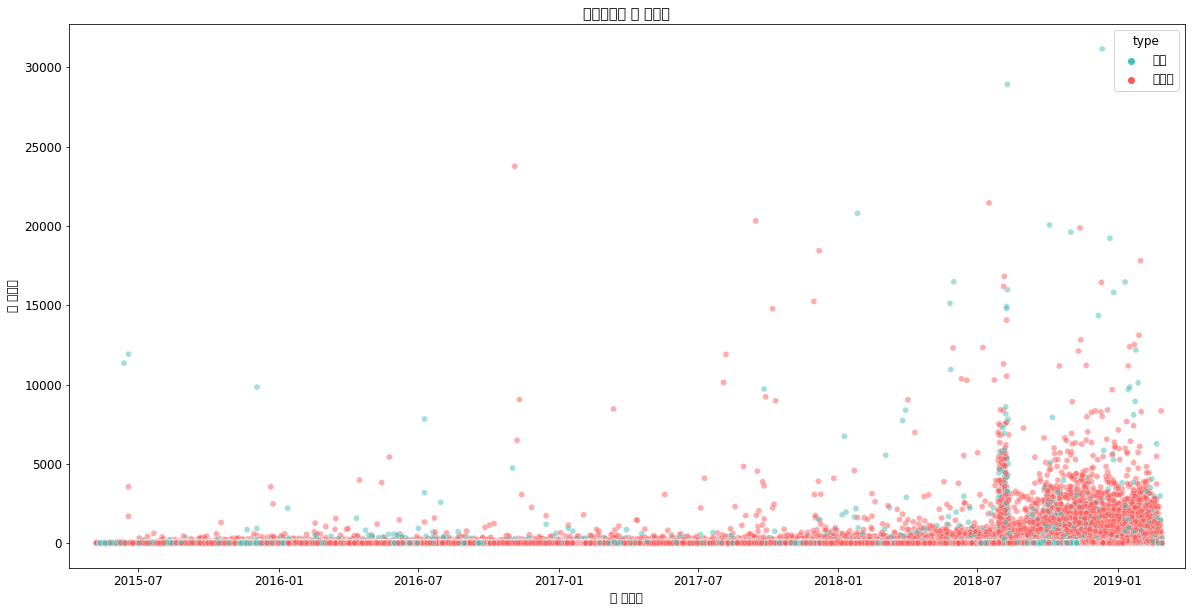

In [219]:
# 특이값 2개 데이터를 제외
lm = sns.scatterplot(data=atc_read_cnt_nn[~atc_read_cnt_nn.article_id.isin(['@brunch_141', '@brunch_151'])], x='reg_dt', y='read_cnt', hue='type', alpha=0.5, palette=['#49beb7', '#ff5959'])
lm.set(xlim=(datetime.date(datetime(2015, 4, 1)), datetime.date(datetime(2019, 3, 30))))
plt.title('등록일자별 글 소비수')
plt.xlabel('글 등록일')
plt.ylabel('글 소비수')

## 3. 경과일에 따른 글 소비 변화

### a. 데이터 전처리


In [221]:
off_data = pd.merge(read_raw, atc, how='inner', left_on='article_id', right_on='article_id')


In [222]:
off_data.shape


(20905040, 15)

In [225]:
off_data.head()


,dt,hr,user_id,article_id,magazine_id,author_id,title,keyword_list,display_url,sub_title,reg_ts,id,reg_datetime,reg_dt,type
0,20181121,14,#a055d0c3520e1c002531001928217887,@charlessay_30,37242,@charlessay,프랑스 인큐베이팅 프로그램 킥오프(2),"[IT, 스타트업]",https://brunch.co.kr/@charlessay/30,자신의 비전을 이루기 위해 여행을 떠나는 길동무들,1542529515000,30,2018-11-18 17:25:15,2018-11-18,매거진
1,20181118,18,#585b5346c56d6d0ed6341afe382e03b7,@charlessay_30,37242,@charlessay,프랑스 인큐베이팅 프로그램 킥오프(2),"[IT, 스타트업]",https://brunch.co.kr/@charlessay/30,자신의 비전을 이루기 위해 여행을 떠나는 길동무들,1542529515000,30,2018-11-18 17:25:15,2018-11-18,매거진
2,20181118,18,#ad179b8f764c4c56f048ba337daee781,@charlessay_30,37242,@charlessay,프랑스 인큐베이팅 프로그램 킥오프(2),"[IT, 스타트업]",https://brunch.co.kr/@charlessay/30,자신의 비전을 이루기 위해 여행을 떠나는 길동무들,1542529515000,30,2018-11-18 17:25:15,2018-11-18,매거진
3,20181119,12,#3cb3edc483bc5d9bd95b677b97a3521c,@charlessay_30,37242,@charlessay,프랑스 인큐베이팅 프로그램 킥오프(2),"[IT, 스타트업]",https://brunch.co.kr/@charlessay/30,자신의 비전을 이루기 위해 여행을 떠나는 길동무들,1542529515000,30,2018-11-18 17:25:15,2018-11-18,매거진
4,20181122,19,#e714f32a816fd9c8e553cd7a7573b71c,@charlessay_30,37242,@charlessay,프랑스 인큐베이팅 프로그램 킥오프(2),"[IT, 스타트업]",https://brunch.co.kr/@charlessay/30,자신의 비전을 이루기 위해 여행을 떠나는 길동무들,1542529515000,30,2018-11-18 17:25:15,2018-11-18,매거진


In [227]:

# off_data.columns = ['read_dt', 'hr', 'user_id', 'article_id', 'article_seq', 'display_url',
#                     'keyword_list', 'magazine_id', 'reg_ts', 'sub_title', 'title',
#                     'author_id', 'reg_datetime', 'reg_dt', 'type']

off_data.columns = ['read_dt', 'hr', 'user_id', 'article_id',
                    'magazine_id', 'author_id', 'title', 'keyword_list',
                    'display_url', 'sub_title',
                    'reg_ts', 'article_seq', 'reg_datetime', 
                    'reg_dt', 'type']



In [229]:
off_data = off_data[['read_dt', 'user_id', 'article_id', 
                     'title', 'sub_title', 'author_id', 
                     'reg_dt', 'type', 'display_url', 
                     'keyword_list', 'magazine_id']]



In [232]:
off_data['read_dt'] = pd.to_datetime(off_data['read_dt'], format='%Y%m%d')
off_data['reg_dt'] = pd.to_datetime(off_data['reg_dt'], format='%Y-%m-%d')
off_data['off_day'] = (off_data['read_dt'] - off_data['reg_dt']).dt.days

In [233]:
# meatadata와 join
off_data = pd.merge(off_data, atc_read_cnt_nn[['article_id', 'read_cnt', 'class']], how='left', left_on='article_id', right_on='article_id')



In [235]:
off_data.shape


(20905040, 14)

In [236]:
off_data.head()

,read_dt,user_id,article_id,title,sub_title,author_id,reg_dt,type,display_url,keyword_list,magazine_id,off_day,read_cnt,class
0,2018-11-21,#a055d0c3520e1c002531001928217887,@charlessay_30,프랑스 인큐베이팅 프로그램 킥오프(2),자신의 비전을 이루기 위해 여행을 떠나는 길동무들,@charlessay,2018-11-18,매거진,https://brunch.co.kr/@charlessay/30,"[IT, 스타트업]",37242,3,31,25%
1,2018-11-18,#585b5346c56d6d0ed6341afe382e03b7,@charlessay_30,프랑스 인큐베이팅 프로그램 킥오프(2),자신의 비전을 이루기 위해 여행을 떠나는 길동무들,@charlessay,2018-11-18,매거진,https://brunch.co.kr/@charlessay/30,"[IT, 스타트업]",37242,0,31,25%
2,2018-11-18,#ad179b8f764c4c56f048ba337daee781,@charlessay_30,프랑스 인큐베이팅 프로그램 킥오프(2),자신의 비전을 이루기 위해 여행을 떠나는 길동무들,@charlessay,2018-11-18,매거진,https://brunch.co.kr/@charlessay/30,"[IT, 스타트업]",37242,0,31,25%
3,2018-11-19,#3cb3edc483bc5d9bd95b677b97a3521c,@charlessay_30,프랑스 인큐베이팅 프로그램 킥오프(2),자신의 비전을 이루기 위해 여행을 떠나는 길동무들,@charlessay,2018-11-18,매거진,https://brunch.co.kr/@charlessay/30,"[IT, 스타트업]",37242,1,31,25%
4,2018-11-22,#e714f32a816fd9c8e553cd7a7573b71c,@charlessay_30,프랑스 인큐베이팅 프로그램 킥오프(2),자신의 비전을 이루기 위해 여행을 떠나는 길동무들,@charlessay,2018-11-18,매거진,https://brunch.co.kr/@charlessay/30,"[IT, 스타트업]",37242,4,31,25%


In [237]:
off_data_agg = off_data.groupby(['article_id', 'off_day', 'read_dt', 'reg_dt', 'title', 'author_id', 'type', 'display_url', 'magazine_id', 'class'], as_index=False)['user_id'].count()


In [238]:
# 등록일자가 missing된 로그들
off_data_agg[off_data_agg.off_day < 0].head()

,article_id,off_day,read_dt,reg_dt,title,author_id,type,display_url,magazine_id,class,user_id
166,@01023920600_18,-26324,2018-12-05,2090-12-31,김영화가,@01023920600,매거진,https://brunch.co.kr/@01023920600/18,8123,75%,2
167,@01023920600_18,-26303,2018-12-26,2090-12-31,김영화가,@01023920600,매거진,https://brunch.co.kr/@01023920600/18,8123,75%,2
168,@01023920600_18,-26280,2019-01-18,2090-12-31,김영화가,@01023920600,매거진,https://brunch.co.kr/@01023920600/18,8123,75%,1
172,@01023920600_2,-26324,2018-12-05,2090-12-31,효자되는 소액투자 돈불리는 소액투자,@01023920600,개인,https://brunch.co.kr/@01023920600/2,0,75%,2
173,@01023920600_2,-26303,2018-12-26,2090-12-31,효자되는 소액투자 돈불리는 소액투자,@01023920600,개인,https://brunch.co.kr/@01023920600/2,0,75%,2


### b. 경과일에 따른 글 소비 변화


In [240]:
# 경과일자별 소비수 총합
off_day_sum = off_data_agg[(off_data_agg['reg_dt'] >= datetime(2018, 10, 1)) & (off_data_agg.off_day >= 0)].groupby('off_day')['user_id'].sum()



In [241]:
# 경과일자에 등록되어있는 아티클 수
reg_dt_cnt = off_data_agg[(off_data_agg['reg_dt'] >= datetime(2018, 10, 1)) & (off_data_agg.off_day >= 0)].groupby('reg_dt')['article_id'].nunique()



In [242]:
off_day_avg = pd.concat([off_day_sum, reg_dt_cnt.cumsum().sort_index(ascending=False).reset_index()], axis=1)


In [243]:
off_day_avg['off_avg'] = off_day_avg['user_id'] / off_day_avg['article_id']


In [244]:
off_day_avg['percentile'] = off_day_avg['off_avg'] / off_day_avg['off_avg'].sum()


In [245]:
off_day_avg['cum_per'] = off_day_avg['percentile'].cumsum()


In [246]:
off_day_avg.head(10)


,user_id,reg_dt,article_id,off_avg,percentile,cum_per
0,3142049,2019-02-28,107356,29.267568,0.207084,0.207084
1,1726882,2019-02-27,106649,16.192201,0.114569,0.321653
2,1017862,2019-02-26,105891,9.612356,0.068013,0.389665
3,776093,2019-02-25,105156,7.380397,0.052220,0.441886
4,632960,2019-02-24,104308,6.068183,0.042936,0.484821
5,529081,2019-02-23,103611,5.106417,0.036131,0.520952
6,436611,2019-02-22,103019,4.238160,0.029987,0.550939
7,412530,2019-02-21,102167,4.037801,0.028570,0.579509
8,236772,2019-02-20,101343,2.336343,0.016531,0.596040
9,193039,2019-02-19,100511,1.920576,0.013589,0.609629


Text(0, 0.5, '평균 글 소비수')

/Users/ohyeji/anaconda3/envs/tf2/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 44221 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/ohyeji/anaconda3/envs/tf2/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 44284 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/ohyeji/anaconda3/envs/tf2/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 51068 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/ohyeji/anaconda3/envs/tf2/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 50640 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/ohyeji/anaconda3/envs/tf2/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 46384 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/ohyeji/anaconda3/envs/tf2/li

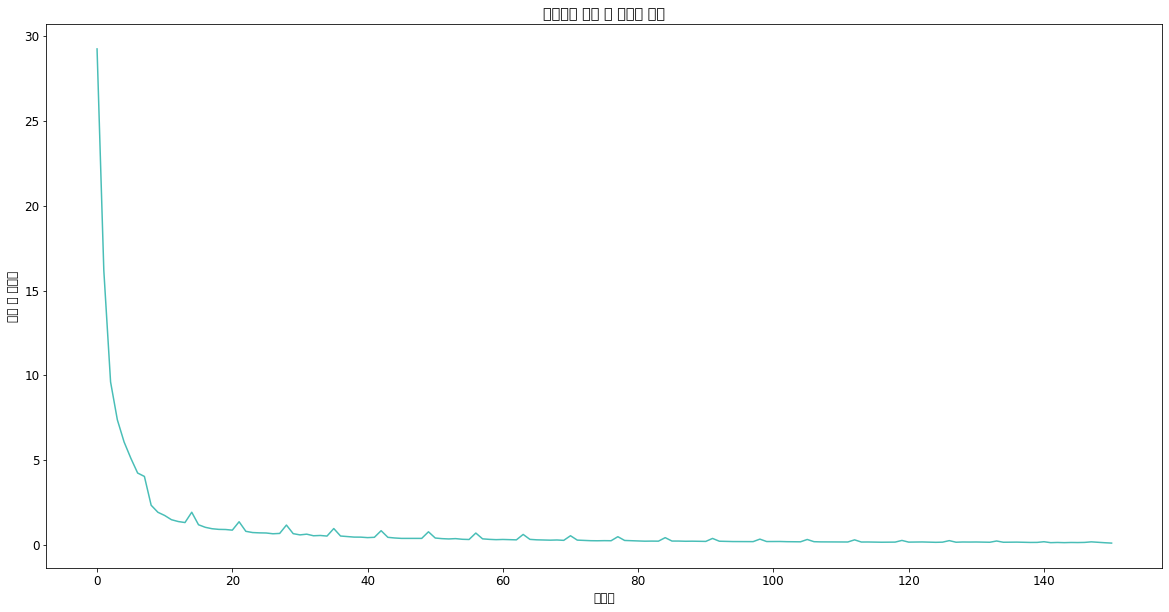

In [247]:
sns.lineplot(data=off_day_avg, x=off_day_avg.index, y='off_avg', color='#49beb7')
plt.title('경과일에 따른 글 소비수 변화')
plt.xlabel('경과일')
plt.ylabel('평균 글 소비수')

## 4. 위클리 매거진


In [248]:
magazine_34075 = atc_read_cnt_nn[atc_read_cnt_nn.magazine_id == 34075]


In [249]:
# Weekly매거진 회사 체질이 아니라서요 (by 서메리) 글 목록
magazine_34075

,article_id,read_cnt,magazine_id,author_id,title,keyword_list,display_url,sub_title,reg_ts,id,reg_datetime,reg_dt,type,class
299425,@merryseo_51,3946,34075.0,@merryseo,"""프리랜서입니다""","[퇴사, 일러스트, 에세이]",https://brunch.co.kr/@merryseo/51,기술도 없는 사무직 퇴사자의 프리랜서 도전기,1.532531e+12,51.0,2018-07-26,2018-07-26,매거진,5%
299426,@merryseo_52,4906,34075.0,@merryseo,퇴사를 결심하다,"[퇴사, 에세이, 일러스트]",https://brunch.co.kr/@merryseo/52,기술도 없는 사무직 퇴사자의 프리랜서 도전기,1.533136e+12,52.0,2018-08-02,2018-08-02,매거진,5%
299427,@merryseo_53,7620,34075.0,@merryseo,회사 체질이 아니야,"[퇴사, 에세이, 일러스트]",https://brunch.co.kr/@merryseo/53,기술도 없는 사무직 퇴사자의 프리랜서 도전기,1.533740e+12,53.0,2018-08-09,2018-08-09,매거진,5%
299428,@merryseo_54,3134,34075.0,@merryseo,프리랜서? 좋지. 근데 기술은 있고?,"[퇴사, 프리랜서, 에세이]",https://brunch.co.kr/@merryseo/54,기술도 없는 사무직 퇴사자의 프리랜서 도전기,1.534345e+12,54.0,2018-08-16,2018-08-16,매거진,5%
299429,@merryseo_55,3112,34075.0,@merryseo,생각보다 넓고 깊은 프리랜서의 세계,"[프리랜서, 퇴사, 에세이]",https://brunch.co.kr/@merryseo/55,기술도 없는 사무직 퇴사자의 프리랜서 도전기,1.534950e+12,55.0,2018-08-23,2018-08-23,매거진,5%
299430,@merryseo_56,2942,34075.0,@merryseo,세상에서 가장 소심한 퇴사 준비,"[퇴사, 프리랜서, 에세이]",https://brunch.co.kr/@merryseo/56,기술도 없는 사무직 퇴사자의 프리랜서 도전기,1.535555e+12,56.0,2018-08-30,2018-08-30,매거진,5%
299431,@merryseo_57,2745,34075.0,@merryseo,한 달 동안의 아주 사치스러운 백수 생활,"[퇴사, 프리랜서, 에세이]",https://brunch.co.kr/@merryseo/57,기술도 없는 사무직 퇴사자의 프리랜서 도전기,1.536160e+12,57.0,2018-09-06,2018-09-06,매거진,5%
299432,@merryseo_58,2522,34075.0,@merryseo,이렇게 평범한 내가 프리랜서를?,"[퇴사, 프리랜서, 에세이]",https://brunch.co.kr/@merryseo/58,기술도 없는 사무직 퇴사자의 프리랜서 도전기,1.536764e+12,58.0,2018-09-13,2018-09-13,매거진,5%
299433,@merryseo_59,2687,34075.0,@merryseo,역시 사람은 기술을 배워야 혀~,"[프리랜서, 퇴사, 에세이]",https://brunch.co.kr/@merryseo/59,기술도 없는 사무직 퇴사자의 프리랜서 도전기,1.537369e+12,59.0,2018-09-20,2018-09-20,매거진,5%
299435,@merryseo_61,3356,34075.0,@merryseo,뭔가 플러스 알파가 필요해,"[퇴사, 프리랜서, 일상툰]",https://brunch.co.kr/@merryseo/61,기술도 없는 사무직 퇴사자의 프리랜서 도전기,1.537974e+12,61.0,2018-09-27,2018-09-27,매거진,5%


In [250]:
magazine_34075_read = off_data_agg[off_data_agg.magazine_id == 34075]


In [251]:
magazine_34075_read.head()


,article_id,off_day,read_dt,reg_dt,title,author_id,type,display_url,magazine_id,class,user_id
2630367,@merryseo_51,67,2018-10-01,2018-07-26,"""프리랜서입니다""",@merryseo,매거진,https://brunch.co.kr/@merryseo/51,34075,5%,16
2630368,@merryseo_51,68,2018-10-02,2018-07-26,"""프리랜서입니다""",@merryseo,매거진,https://brunch.co.kr/@merryseo/51,34075,5%,25
2630369,@merryseo_51,69,2018-10-03,2018-07-26,"""프리랜서입니다""",@merryseo,매거진,https://brunch.co.kr/@merryseo/51,34075,5%,16
2630370,@merryseo_51,70,2018-10-04,2018-07-26,"""프리랜서입니다""",@merryseo,매거진,https://brunch.co.kr/@merryseo/51,34075,5%,308
2630371,@merryseo_51,71,2018-10-05,2018-07-26,"""프리랜서입니다""",@merryseo,매거진,https://brunch.co.kr/@merryseo/51,34075,5%,16


Text(0, 0.5, '글 소비수')

/Users/ohyeji/anaconda3/envs/tf2/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 50948 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/ohyeji/anaconda3/envs/tf2/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 53364 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/ohyeji/anaconda3/envs/tf2/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 47532 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/ohyeji/anaconda3/envs/tf2/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 54924 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/ohyeji/anaconda3/envs/tf2/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 49324 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/ohyeji/anaconda3/envs/tf2/li

/Users/ohyeji/anaconda3/envs/tf2/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 44544 missing from current font.
  font.set_text(s, 0, flags=flags)
/Users/ohyeji/anaconda3/envs/tf2/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 49548 missing from current font.
  font.set_text(s, 0, flags=flags)
/Users/ohyeji/anaconda3/envs/tf2/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 48708 missing from current font.
  font.set_text(s, 0, flags=flags)
/Users/ohyeji/anaconda3/envs/tf2/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 51068 missing from current font.
  font.set_text(s, 0, flags=flags)
/Users/ohyeji/anaconda3/envs/tf2/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0, flags=flags)
/Users/ohyeji/anaconda3/envs/tf2/lib/python3.

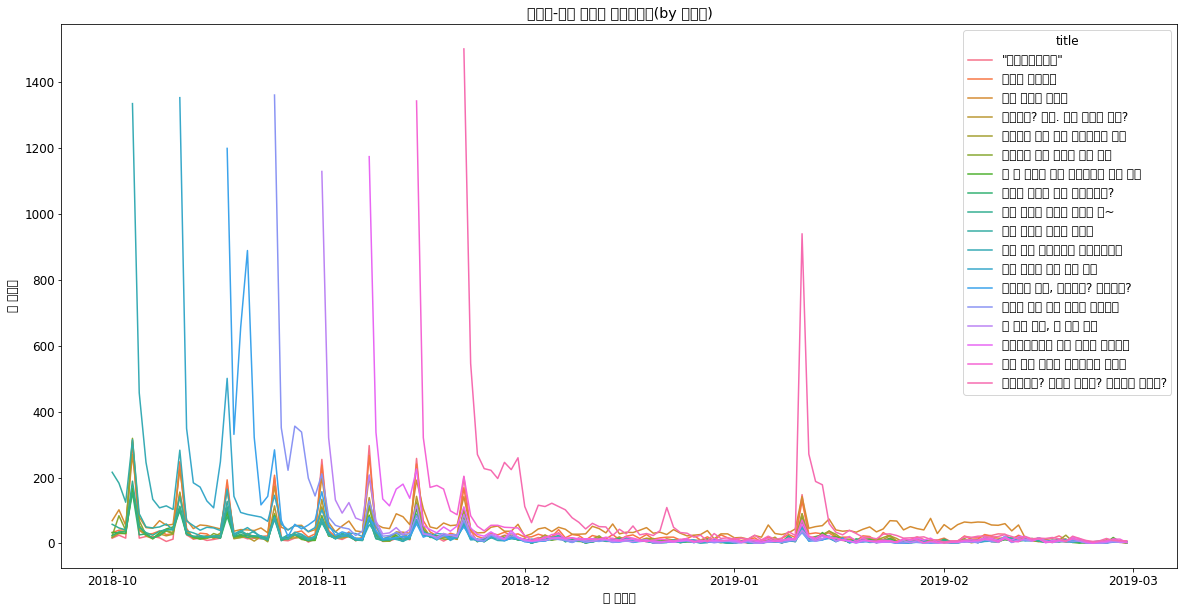

In [252]:
sns.lineplot(data=magazine_34075_read, x='read_dt', y='user_id', hue='title')
plt.title('위클리-회사 체질이 아니라서요(by 서메리)')
plt.xlabel('글 소비일')
plt.ylabel('글 소비수')

In [337]:
# 매거진 태그의 수 저장
n_magazine_tag = []

for i in range(len(magazine['magazine_tag_list'])):
    n_magazine_tag.append(len(magazine['magazine_tag_list'][i]))

In [338]:
# 매거진 태그의 수 (0~6개)
n_magazine_tag = np.array(n_magazine_tag)
sorted_m_tag = np.sort(n_magazine_tag)[::-1]
sorted_m_tag

array([6, 5, 5, ..., 1, 1, 0])

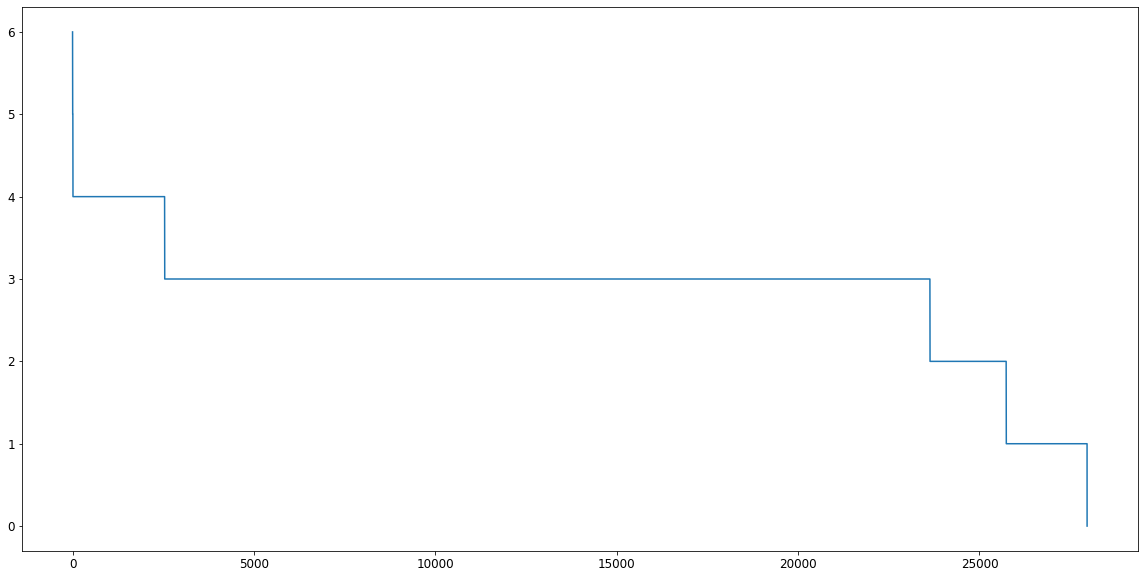

In [339]:
# 매거진 태그의 수 (대부분 3개)
plt.plot(sorted_m_tag)
plt.show()

## 5. 유저


In [254]:
# 유져별 방문일수, 글 소비수
grp_by_user = off_data.groupby('user_id').agg({'read_dt':['nunique', 'count']})


In [255]:
grp_by_user = grp_by_user.reset_index()
grp_by_user.columns = ['user_id', 'visit_day_cnt', 'read_cnt']

In [256]:
grp_by_user.head()


,user_id,visit_day_cnt,read_cnt
0,#00001ba6ca8d87d2fc34d626ba9cfe6f,1,3
1,#0000e87158c1426d6ffb72cebac6cb64,1,2
2,#0000eea6d339abfd02ed590bc451fc63,1,1
3,#0000fdba8f35c76eacab74c5c6bc7f1a,3,11
4,#000127ad0f1981cae1292efdb228f0e9,1,27


### a. 방문일수 기준 유저 통계


In [257]:
grp_by_user['visit_day_cnt'].value_counts(normalize=True).head()


1    0.352137
2    0.142516
3    0.088841
4    0.063050
5    0.047217
Name: visit_day_cnt, dtype: float64

In [258]:
grp_by_user['visit_day_cnt'].value_counts(normalize=True).sort_index()[74:].sum()


0.009034902176890052

- 1~2회 방문 유저 전체 유저중 50%
- 75회 이상 방문하는유저 전체 유저중 약 1%
- 1~2일 방문유저를 신규유저 / 75일(Train 기간 절반 방문) 방문 유저를 단골유저로 구분

In [259]:
# 하루에 2번보다 적게 방문하는 유저 (=신규유저)
low_visit_user = grp_by_user.loc[grp_by_user['visit_day_cnt'] <=2, 'user_id']



In [262]:
# 하루에 75번보다 많이 방문하는 유저 (=단골유저)
upp_visit_user = grp_by_user.loc[grp_by_user['visit_day_cnt'] >=75, 'user_id']


In [263]:
low_visit_user.shape, upp_visit_user.shape


((149903,), (2738,))

In [264]:
off_data_l = off_data[off_data.user_id.isin(low_visit_user)]
off_data_u = off_data[off_data.user_id.isin(upp_visit_user)]


In [265]:
off_data.shape, off_data_l.shape, off_data_u.shape


((20905040, 14), (1083925, 14), (5002114, 14))

In [266]:
1083925/20905040, 5002114/20905040


(0.051849936665990595, 0.23927789662205862)

신규 유저의 글 소비는 전체의 5%, 단골 유저의 글 소비는 전체의 24%


In [267]:
off_data_l.groupby('user_id')['article_id'].count().mean(), off_data_l.groupby('user_id')['article_id'].count().std(),


(7.230842611555473, 13.573547204833003)

In [268]:
off_data_u.groupby('user_id')['article_id'].count().mean(), off_data_u.groupby('user_id')['article_id'].count().std()


(1826.9225712198686, 2758.1071094196936)

- 신규 유저의 평균 글 소비수는 7, 표준편차 14
- 단골 유저의 평균 글 소비수는 1827, 표준편차 2758

### b. 신규/단골 그룹내 인기 글

In [269]:
off_data_l_rk = off_data_l.groupby(['article_id', 'title', 'reg_dt'])['user_id'].count().sort_values(ascending=False)
off_data_l_rk = off_data_l_rk.reset_index()
off_data_l_rk['rk'] = off_data_l_rk.index + 1

In [270]:
off_data_u_rk = off_data_u.groupby(['article_id', 'title', 'reg_dt'])['user_id'].count().sort_values(ascending=False)
off_data_u_rk = off_data_u_rk.reset_index()
off_data_u_rk['rk'] = off_data_u_rk.index + 1

In [271]:
# 신규 독자 소비수 상위 상위 10개 글
off_data_l_rk.head(10)

,article_id,title,reg_dt,user_id,rk
0,@brunch_141,브런치 작가가 함께 빨강머리 앤을 그리고 쓰다.,2018-10-17,13519,1
1,@brunch_151,"브런치 무비 패스, 영화의 진한 여운을 나누세요",2019-02-18,8160,2
2,@brunch_1,"글이 작품이 되는 공간, 브런치",2015-06-12,5282,3
3,@brunch_140,카카오 크리에이터스 스튜디오에서 브런치 작가를 만나다.,2018-10-04,4343,4
4,@brunch_2,브런치 작가 신청 안내,2015-06-18,4068,5
5,@brunch_145,"10인의 에디터와 함께 하는, 브런치북 프로젝트 #6",2018-12-12,2897,6
6,@brunch_133,"또 다른 기회의 시작, 브런치와 함께하세요",2018-07-09,2640,7
7,@kakaomobility_20,음성으로 편리하게,2018-10-17,2458,8
8,@intlovesong_28,아끼면 똥 되는 것 4가지,2016-11-04,2226,9
9,@brunch_142,[예고] 브런치북 프로젝트 #6,2018-11-01,2221,10


In [272]:
# 단골 독자 소비수 상위 상위 10개 글
off_data_u_rk.head(10)

,article_id,title,reg_dt,user_id,rk
0,@brunch_141,브런치 작가가 함께 빨강머리 앤을 그리고 쓰다.,2018-10-17,11636,1
1,@brunch_151,"브런치 무비 패스, 영화의 진한 여운을 나누세요",2019-02-18,6010,2
2,@brunch_145,"10인의 에디터와 함께 하는, 브런치북 프로젝트 #6",2018-12-12,4379,3
3,@tenbody_1305,러닝머신보다 효과 좋은 체지방 빼는 맨몸 운동 5가지,2018-08-10,3674,4
4,@hyehyodam_19,나쁜년이 잘 사는 이유...,2018-01-26,2920,5
5,@sangheeshyn_66,살찌지 않는 여자들,2018-11-13,2866,6
6,@brunch_142,[예고] 브런치북 프로젝트 #6,2018-11-01,2753,7
7,@intlovesong_28,아끼면 똥 되는 것 4가지,2016-11-04,2606,8
8,@x-xv_19,"승무원, 들어오려는 자, 나가려는 자",2018-08-05,2603,9
9,@steven_179,친구 없는 사람의 3가지 특징,2017-09-15,2597,10


In [273]:
off_data_lu_rk = pd.merge(off_data_l_rk, off_data_u_rk, how='outer', left_on = 'article_id', right_on='article_id')


In [274]:
# 신규 독자, 단골 독자 글 순위 합치기. 이때 rk값의 차이를 diff-rk로 함. 

off_data_lu_rk['diff_rk'] = off_data_lu_rk['rk_x'] - off_data_lu_rk['rk_y']


In [277]:
off_data_lu_rk.head()

,article_id,title_x,reg_dt_x,user_id_x,rk_x,title_y,reg_dt_y,user_id_y,rk_y,diff_rk
0,@brunch_141,브런치 작가가 함께 빨강머리 앤을 그리고 쓰다.,2018-10-17,13519.0,1.0,브런치 작가가 함께 빨강머리 앤을 그리고 쓰다.,2018-10-17,11636.0,1.0,0.0
1,@brunch_151,"브런치 무비 패스, 영화의 진한 여운을 나누세요",2019-02-18,8160.0,2.0,"브런치 무비 패스, 영화의 진한 여운을 나누세요",2019-02-18,6010.0,2.0,0.0
2,@brunch_1,"글이 작품이 되는 공간, 브런치",2015-06-12,5282.0,3.0,"글이 작품이 되는 공간, 브런치",2015-06-12,528.0,569.0,-566.0
3,@brunch_140,카카오 크리에이터스 스튜디오에서 브런치 작가를 만나다.,2018-10-04,4343.0,4.0,카카오 크리에이터스 스튜디오에서 브런치 작가를 만나다.,2018-10-04,1808.0,26.0,-22.0
4,@brunch_2,브런치 작가 신청 안내,2015-06-18,4068.0,5.0,브런치 작가 신청 안내,2015-06-18,232.0,3216.0,-3211.0


In [275]:
# 신규 독자 소비수 상위 50개 글 중 단골 독자의 순위 차가 많이 나는 글 (10개)
off_data_lu_rk[off_data_lu_rk.rk_x <= 50].sort_values(by='diff_rk', ascending=True).head(10)


,article_id,title_x,reg_dt_x,user_id_x,rk_x,title_y,reg_dt_y,user_id_y,rk_y,diff_rk
7,@kakaomobility_20,음성으로 편리하게,2018-10-17,2458.0,8.0,음성으로 편리하게,2018-10-17,14.0,64179.0,-64171.0
4,@brunch_2,브런치 작가 신청 안내,2015-06-18,4068.0,5.0,브런치 작가 신청 안내,2015-06-18,232.0,3216.0,-3211.0
33,@brunch_139,작가님에게 새로운 제안이 도착했습니다,2018-08-08,1047.0,34.0,작가님에게 새로운 제안이 도착했습니다,2018-08-08,474.0,750.0,-716.0
18,@brunch_152,작가 인터뷰 - 임희정 아나운서의 고백,2019-02-27,1611.0,19.0,작가 인터뷰 - 임희정 아나운서의 고백,2019-02-27,480.0,730.0,-711.0
2,@brunch_1,"글이 작품이 되는 공간, 브런치",2015-06-12,5282.0,3.0,"글이 작품이 되는 공간, 브런치",2015-06-12,528.0,569.0,-566.0
26,@brunch_111,브런치 책방에 작가님의 책을 입고해주세요,2017-09-28,1326.0,27.0,브런치 책방에 작가님의 책을 입고해주세요,2017-09-28,702.0,315.0,-288.0
35,@jmg5308_163,이효리를 통해 바라본 자존감 높은 사람의 특징,2017-08-04,995.0,36.0,이효리를 통해 바라본 자존감 높은 사람의 특징,2017-08-04,795.0,233.0,-197.0
38,@dong02_1372,자존감을 높이는 언어습관 3가지 방법,2017-10-11,876.0,39.0,자존감을 높이는 언어습관 3가지 방법,2017-10-11,880.0,185.0,-146.0
31,@nplusu_49,벨기에의 3가지 보물,2016-11-10,1170.0,32.0,벨기에의 3가지 보물,2016-11-10,900.0,175.0,-143.0
45,@needleworm_1,크롤러를 이용해 우체국 등기우편을 자동으로 정리해 보자,2018-11-01,796.0,46.0,크롤러를 이용해 우체국 등기우편을 자동으로 정리해 보자,2018-11-01,905.0,173.0,-127.0


In [278]:
# 단골 독자 소비수 상위 50개 글 중 신규 독자의 순위 차가 많이 나는 긂
off_data_lu_rk[off_data_lu_rk.rk_y <= 50].sort_values(by='diff_rk', ascending=False).head(10)


,article_id,title_x,reg_dt_x,user_id_x,rk_x,title_y,reg_dt_y,user_id_y,rk_y,diff_rk
753,@doyeonsunim_240,자기 관리의 시작,2018-08-06,117.0,754.0,자기 관리의 시작,2018-08-06,1608.0,37.0,717.0
504,@boboc_72,"여름, 수박을 먹는 계절",2018-08-12,151.0,505.0,"여름, 수박을 먹는 계절",2018-08-12,1473.0,49.0,456.0
434,@kam_33,많이 먹은 다음날 반드시 지켜야 할 3가지 습관,2018-08-09,167.0,435.0,많이 먹은 다음날 반드시 지켜야 할 3가지 습관,2018-08-09,1751.0,29.0,406.0
261,@jooyoon_51,구질구질한 연애,2018-08-01,227.0,262.0,구질구질한 연애,2018-08-01,1750.0,30.0,232.0
211,@greenut90_85,크림라떼와 브라우니,2018-08-05,257.0,212.0,크림라떼와 브라우니,2018-08-05,1573.0,41.0,171.0
199,@roysday_279,혼자서 어찌어찌 하다보니 1억을 넘겼다.,2018-11-03,266.0,200.0,혼자서 어찌어찌 하다보니 1억을 넘겼다.,2018-11-03,1659.0,36.0,164.0
162,@honeytip_940,뱃살 쏙 들어가게 하는 건강한 먹거리 6가지,2018-08-09,305.0,163.0,뱃살 쏙 들어가게 하는 건강한 먹거리 6가지,2018-08-09,2408.0,12.0,151.0
136,@tenbody_1297,매일 5분씩 참으면서 살 빼고 근육 늘리는 방법,2018-08-09,346.0,137.0,매일 5분씩 참으면서 살 빼고 근육 늘리는 방법,2018-08-09,2244.0,15.0,122.0
149,@merryseo_73,행복한가요? 얼마나 벌어요? 불안하진 않나요?,2018-11-22,318.0,150.0,행복한가요? 얼마나 벌어요? 불안하진 않나요?,2018-11-22,1742.0,31.0,119.0
115,@honeytip_945,물에 오이를 넣어 마시면 생기는 몸의 변화 5가지,2018-08-10,392.0,116.0,물에 오이를 넣어 마시면 생기는 몸의 변화 5가지,2018-08-10,2227.0,16.0,100.0


### c. 검색키워드(keyword_list)가 있는 유저

In [314]:
# keyword_list가 있는 유저
user_with_keyword = users[users['keyword_list'].str.len() !=0 ]

In [315]:
# '검색키워드가 있는 유저', 11,544명
len(user_with_keyword)

11544

In [317]:
user_with_keyword.head()

,keyword_list,following_list,id
6,"[{'cnt': 1, 'keyword': '200일 이벤트'}, {'cnt': 2,...","[@gabrieljmh, @megaonic, @cleancode, @simu-loo...",#d07b31cfd62b7097837eee6b8328e077
18,"[{'cnt': 1, 'keyword': '1층 배란다'}, {'cnt': 1, '...","[@seochogirl, @anti-essay, @ggoforit, @tsp, @i...",#db076cc2fdaca59be7d92ba985b9bfa3
33,"[{'cnt': 1, 'keyword': 'j no14'}, {'cnt': 8, '...","[@hotelmarilyn, @ken1224, @songheeinsweden, @a...",#f3dd6bcd7d12d98bfe583c8895ecbf6d
34,"[{'cnt': 1, 'keyword': '강남역 10번출구'}, {'cnt': 1...","[@cloud09, @choihs0228, @lovesay1123, @missing...",#69ee29d86b9bfe846e8c261064c88235
41,"[{'cnt': 1, 'keyword': '복지기본선'}, {'cnt': 2, 'k...",[@tschoe56],#b13fe4e07bf3e9d27fb35a986481c14d


In [324]:
# '검색키워드 있는 유저'들의 키워드 저장
keyword = []

for i in range(len(users["keyword_list"])):
    if len(users["keyword_list"][i]) > 0:
        keyword.append(users["keyword_list"][i])


In [329]:
# 특정 검색유저의 키워드 (이 유저의 경우 72개의 검색키워드)

keyword[0]

[{'cnt': 1, 'keyword': '200일 이벤트'},
 {'cnt': 2, 'keyword': '4dx 음료'},
 {'cnt': 1, 'keyword': '4dx 주의사항'},
 {'cnt': 1, 'keyword': '8대2가르마펌'},
 {'cnt': 1, 'keyword': 'Gott ist tot'},
 {'cnt': 1, 'keyword': 'kt OPT 빨간불'},
 {'cnt': 1, 'keyword': 'kt opt 불'},
 {'cnt': 1, 'keyword': 'kt 공유기 opt'},
 {'cnt': 3, 'keyword': 'kt 모뎀'},
 {'cnt': 5, 'keyword': 'kt 모뎀 opt'},
 {'cnt': 2, 'keyword': 'kt 모뎀 opt 빨간불'},
 {'cnt': 1, 'keyword': 'kt 인터넷 공유기 빨간불'},
 {'cnt': 1, 'keyword': 'kt 인터넷 모뎀 고장 op'},
 {'cnt': 1, 'keyword': 'kt 인터넷.opt'},
 {'cnt': 2, 'keyword': 'kt공유기 빨간불'},
 {'cnt': 3, 'keyword': 'kt모뎀'},
 {'cnt': 2, 'keyword': 'kt모뎀 opt'},
 {'cnt': 1, 'keyword': 'may the force b'},
 {'cnt': 1, 'keyword': 'opt 에 빨간불'},
 {'cnt': 1, 'keyword': 'v 스쿼트'},
 {'cnt': 1, 'keyword': '가중무게중심'},
 {'cnt': 1, 'keyword': '개헌안'},
 {'cnt': 19, 'keyword': '고프로 타임랩스'},
 {'cnt': 2, 'keyword': '고프로 타임랩스 시간'},
 {'cnt': 1, 'keyword': '고프로 타임랩스란'},
 {'cnt': 1, 'keyword': '고프로 필요한 이유'},
 {'cnt': 1, 'keyword': '고프로타입랩스'},
 {'c

In [330]:
# '검색키워드 있는 유저'들의 검색키워드 수 저장
n_keyword = []

for i in range(len(keyword)):
    n_keyword.append(len(keyword[i]))

In [331]:
# '검색키워드 있는 유저'들의 검색키워드 수 (평균 40개)
n_keyword = np.array(n_keyword)
np.mean(n_keyword)

40.85524948024948

In [332]:
# 검색키워드 '있는' 유저들의 검색키워드 수 (1 ~ 8265개)
sorted_keyword = np.sort(n_keyword)[::-1]
sorted_keyword

array([8265, 7398, 5997, ...,    1,    1,    1])

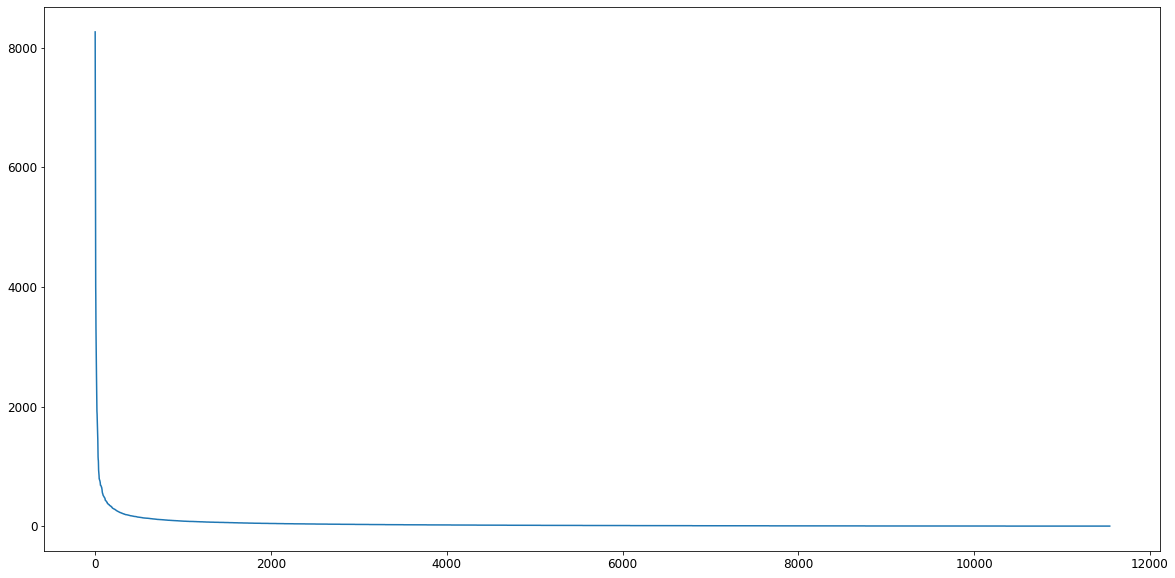

In [333]:
# 검색키워드 '있는' 유저들의 검색키워드 수 (소수의 유저만 검색키워드가 많음)
plt.plot(sorted_keyword)
plt.show()

In [334]:
# 검색키워드 '있는' 유저들의 검색키워드 수 (검색키워드 수 상위 1%의 유저 1154명은 75~8265개의 키워드를 가짐)
sorted_keyword[:int(0.1*len(sorted_keyword))]

array([8265, 7398, 5997, ...,   76,   76,   75])

## 6. Following List


### a. Following List 통계


In [303]:
# following_list가 있는 유저
following = users[users['following_list'].str.len() !=0 ]

In [310]:
# '구독하는 작가가 있는 유저' 총 303,490명
len(following)

303490

In [304]:
following.shape[0] / users.shape[0]


0.9766120260781701

- 98%의 유저가 follow하는 작가가 있음

In [305]:
following['author_cnt'] = users['following_list'].str.len()



/Users/ohyeji/anaconda3/envs/tf2/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [306]:
following.head()

,keyword_list,following_list,id,author_cnt
0,[],"[@perytail, @brunch]",#901985d8bc4c481805c4a4f911814c4a,2
1,[],"[@holidaymemories, @wadiz, @sciforus, @dailydu...",#1fd89e9dcfa64b45020d9eaca54e0eed,75
2,[],"[@commerceguy, @sunsutu, @kakao-it, @joohoonja...",#1d94baaea71a831e1f33e1c6bd126ed5,5
3,[],"[@amberjeon48, @forsy20, @nemotokki, @hawann, ...",#04641c01892b12dc018b1410e4928c0d,84
4,[],"[@dwcha7342, @iammento, @kakao-it, @dkam, @ant...",#65bcaff862aadff877e461f54187ab62,19


In [307]:
#평균 구독자수 
following['author_cnt'].mean()

8.622620185179084

- follow하고 있는 유저는 평균 9명의 작가를 구독 중


In [283]:
following['following_list'] = following['following_list'].apply(lambda x: ' '.join(x))


/Users/ohyeji/anaconda3/envs/tf2/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [287]:
def chainer(s):
    return list(chain.from_iterable(s.str.split(' ')))

In [288]:
following_lens = following['following_list'].str.split(' ').map(len)


In [291]:
following_lens

0          2
1         75
2          5
3         84
4         19
          ..
310752    62
310753    41
310754    17
310755     4
310756    20
Name: following_list, Length: 303490, dtype: int64

In [290]:
following_raw = pd.DataFrame({'id': np.repeat(following['id'], following_lens),
                         'following_list': chainer(following['following_list'])})


In [294]:
following_raw.head()

,id,following_list
0,#901985d8bc4c481805c4a4f911814c4a,@perytail
0,#901985d8bc4c481805c4a4f911814c4a,@brunch
1,#1fd89e9dcfa64b45020d9eaca54e0eed,@holidaymemories
1,#1fd89e9dcfa64b45020d9eaca54e0eed,@wadiz
1,#1fd89e9dcfa64b45020d9eaca54e0eed,@sciforus


In [292]:
# 가장 구독하는 유저가 많은 작가 리스트
following_raw['following_list'].value_counts(ascending=False)[:20]

@brunch         292413
@dryjshin         9011
@tenbody          8615
@roysday          8500
@yumileewyky      6116
@varo             5688
@yoonash          5653
@imagineer        5483
@lunarshore       5414
@ebprux           5374
@haneulalice      5341
@suhanjang        4911
@daljasee         4756
@mobiinside       4743
@sustainlife      4655
@bang1999         4577
@seochogirl       4441
@annejeong        4426
@eastgo           4387
@hyejinchoi       4305
Name: following_list, dtype: int64

In [295]:
following_read = pd.merge(off_data, following_raw, how='inner', left_on=['user_id', 'author_id'], right_on=['id', 'following_list'])


In [296]:
following_read.shape[0] / off_data.shape[0]


0.3485478621423351

- 전체 소비 데이터중 구독하고 있는 작가의 글 소비 비중이 35%


In [308]:
# '구독하는 작가가 있는 유저'들이 구독하는 작가의 수 (1 ~ 3528명)
sorted_following = np.sort(following_lens)[::-1]

sorted_following

array([3528, 3098, 2938, ...,    1,    1,    1])

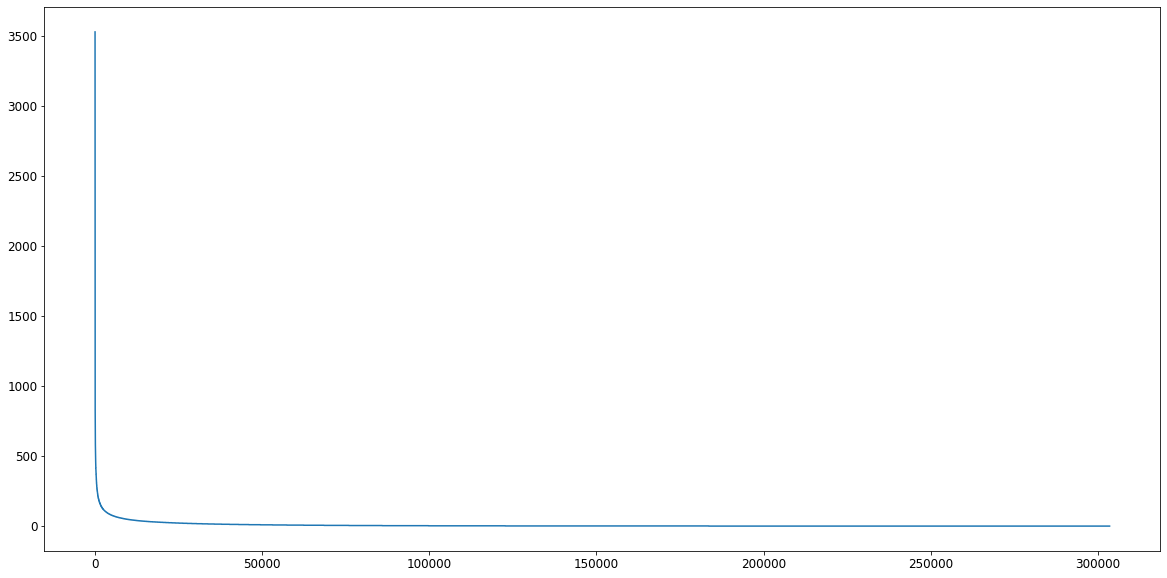

In [309]:
# '구독하는 작가가 있는 유저'들이 구독하는 작가의 수 (소수의 유저만 구독 많이함)
plt.plot(sorted_following)
plt.show()

## 7. 메타데이터(metadata) 분석

In [340]:
metadata = pd.read_json(directory + 'metadata.json', lines=True)


In [341]:
metadata.shape


(643104, 9)

In [342]:
metadata.head()


,magazine_id,user_id,title,keyword_list,display_url,sub_title,reg_ts,article_id,id
0,8982,@bookdb,"사진으로 옮기기에도 아까운, 리치필드 국립공원","[여행, 호주, 국립공원]",https://brunch.co.kr/@bookdb/782,세상 어디에도 없는 호주 Top 10,1474944427000,782,@bookdb_782
1,12081,@kohwang56,[시] 서러운 봄,"[목련꽃, 아지랑이, 동행]",https://brunch.co.kr/@kohwang56/81,,1463092749000,81,@kohwang56_81
2,0,@hannahajink,무엇을 위해,[],https://brunch.co.kr/@hannahajink/4,무엇 때문에,1447997287000,4,@hannahajink_4
3,16315,@bryceandjuli,싫다,"[감정, 마음, 위로]",https://brunch.co.kr/@bryceandjuli/88,,1491055161000,88,@bryceandjuli_88
4,29363,@mijeongpark,Dubliner#7,"[유럽여행, 더블린, 아일랜드]",https://brunch.co.kr/@mijeongpark/34,#7. 내 친구의 집은 어디인가,1523292942000,34,@mijeongpark_34


In [343]:
# 글의 태그
metadata['keyword_list']

0            [여행, 호주, 국립공원]
1           [목련꽃, 아지랑이, 동행]
2                        []
3              [감정, 마음, 위로]
4         [유럽여행, 더블린, 아일랜드]
                ...        
643099        [3D, UI, 제스처]
643100    [독서모임, 경험수집, 글쓰기]
643101       [생각, 에세이, 괴로움]
643102      [여행, 유럽여행, 리스본]
643103        [리스본, 여행, 유럽]
Name: keyword_list, Length: 643104, dtype: object

In [344]:
# 글의 태그의 수 저장
n_meta_tag = []

for i in range(len(metadata['keyword_list'])):
    n_meta_tag.append(len(metadata['keyword_list'][i]))

In [345]:
# 글의 태그의 수 (0~5개)
n_meta_tag = np.array(n_meta_tag)
sorted_meta_tag = np.sort(n_meta_tag)[::-1]
sorted_meta_tag

array([5, 5, 5, ..., 0, 0, 0])

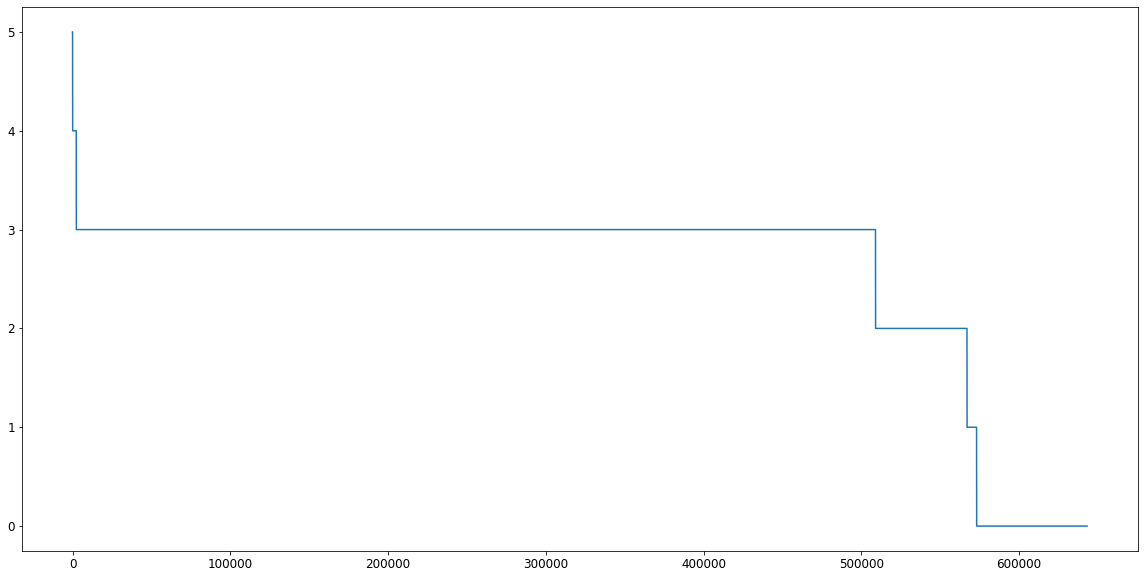

In [ ]:
# 글의 태그의 수 (대부분 3개)
plt.plot(sorted_meta_tag)
plt.show()